In [1]:
from performance_plots import *

ROOT = os.getenv('MB_ROOT_PATH')
sys.path.append(ROOT)
DATA = os.getenv('MB_DATA_PATH')
from tools.processing import *

# Plot Models by Number of dims

## features

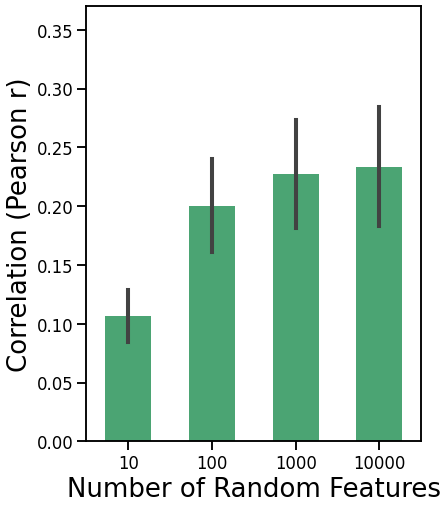

In [43]:
dataset = 'naturalscenes'
regions = ['general']
#regions = ['V1','V2','V3','V4']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'ridgecv'
MAX_POOL = True

data_dict = { 


    'expansion model 3L 10':{
                'iden':'expansion_model_final',
                #'model':ExpansionModel(filters_3=10).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10,
                'max_pool':MAX_POOL,
                },


    'expansion model 3L 100':{
                'iden':'expansion_model_final',
                #'model':ExpansionModel(filters_3=100).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':100,
                'max_pool':MAX_POOL,}, 

    
    'expansion model 3L 1000':{
                'iden':'expansion_model_final',
                #'model':ExpansionModel(filters_3=1000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':1000,
                'max_pool':MAX_POOL,
                },  

 

    'expansion model 3L 10000':{
                'iden':'expansion_model_final',
               # 'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL,
                },
    
    }        
plot_data_means_vs_features(data_dict, dataset, regions, mode, x_axis = 'num_features',  
                            palette = {'expansion_model_final':'mediumseagreen'}, 
                            ylim = (0,0.37),
                                width = 0.55, show_legend= False, error_bars = False,
                                params = (6,8), 
                                name_dict= None, xlog=False, ylog=False, file_name=f'expansion_{regions}' )

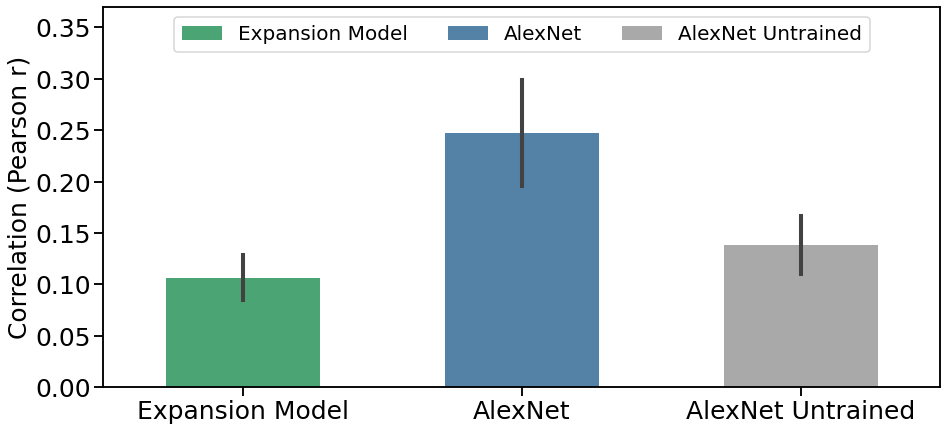

In [3]:

# dataset = 'naturalscenes'
#regions = ['V1','V2','V3','V4']
regions = ['general']
dataset = 'naturalscenes'
#regions = ['general']

mode = 'ridgecv'
MAX_POOL = True

data_dict = {        
        

    'expansion model 3L 10':{
                'iden':'expansion_model_final',
                #'model':ExpansionModel(filters_3=10).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10,
                'max_pool':MAX_POOL,
                },
    
       'alexnet conv5':{
                'iden':'alexnet_conv5',
                #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'}, 

        'alexnet u conv5':{
                'iden':'alexnet_u_conv5',
                #'model':AlexnetU(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'}, 
    
    
    
  
}



name_dict  = {
       'alexnet_conv5':'AlexNet',            
       'alexnet_u_conv5':'AlexNet Untrained', 
   'expansion_model_final':'Expansion Model'
   

}

palette = {         
    'AlexNet Untrained':'darkgray',
    'AlexNet':'steelblue',  
   'Expansion Model':'mediumseagreen'
       

}

plt.clf()
plot_diff_models(data_dict, dataset, regions, mode, name_dict = name_dict, color = None, palette = palette,
                            error_bars = False, ylim = (0.0, 0.37), width=0.55,show_legend = True,
                            params= (15, 7), xlog = False, x_axis = 'num_features', 
                            file_name =  f'alexnet_{regions}')


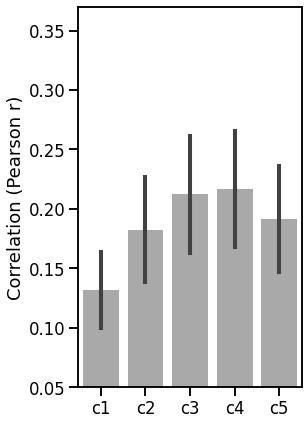

In [15]:
dataset = 'naturalscenes'
regions = ['V1','V2','V3','V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'ridgecv'
MAX_POOL = True

baseline_dict = {        
        
           
    
       'alexnet u conv1':{
                'iden':'alexnet_u_conv1',
                #'model':AlexnetU(features_layer =2, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':1,
                'num_features':64,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,},   
       
        'alexnet u conv2':{
                'iden':'alexnet_u_conv2',
                #'model':AlexnetU(features_layer =5, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':2,
                'num_features':192,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,},   
       
        'alexnet u conv3':{
                'iden':'alexnet_u_conv3',
                #'model':AlexnetU(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':384,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,},   
       
        'alexnet u conv4':{
                'iden':'alexnet_u_conv4',
                #'model':AlexnetU(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':4,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,},       
        
        'alexnet u':{
                'iden':'alexnet_u_conv5',
                #'model':AlexnetU(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,},     
}



name_dict  = {
       # 'alexnet_conv1':'conv1',            
       # 'alexnet_conv2':'conv2', 
       # 'alexnet_conv3':'conv3',   
       # 'alexnet_conv4':'conv4', 
       # 'alexnet':'conv5', 
   
    
       'alexnet_u_conv1':'c1',   
       'alexnet_u_conv2':'c2',
       'alexnet_u_conv3':'c3',   
       'alexnet_u_conv4':'c4',
       'alexnet_u_conv5':'c5', 
}

baseline_palette = {         
       'c1':'darkgray',   
       'c2':'darkgray',
       'c3':'darkgray',   
       'c4':'darkgray',
       'c5':'darkgray', 
}

plt.clf()

plot_baselines(dataset, regions, mode,  aspect=1, height=6, ylim=(0.05,0.37), show_legend= False, width = 0.8,
                                params = (4,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name='alexnet u')


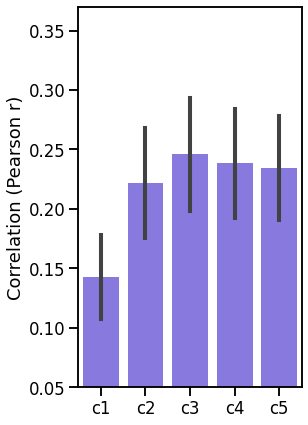

In [14]:
dataset = 'naturalscenes'
regions = ['V1','V2','V3','V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'ridgecv'
MAX_POOL = True

baseline_dict = {        
        
        
       'alexnet conv1':{
                'iden':'alexnet_conv1',
                #'model':Alexnet(features_layer =2, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':1,
                'num_features':64,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,},            
    
       'alexnet conv2':{
                'iden':'alexnet_conv2',
                #'model':Alexnet(features_layer =5, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':2,
                'num_features':192,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,},      
    
       'alexnet conv3':{
                'iden':'alexnet_conv3',
                #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':384,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,},    
    
       'alexnet conv4':{
                'iden':'alexnet_conv4',
               #'model':Alexnet(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':4,
                'n_dims': None,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,},     
        
       'alexnet':{
                'iden':'alexnet_conv5',
               #'model':Alexnet(global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'n_dims': None,
                'num_features':256,
                'max_pool':MAX_POOL,},    
  
}



name_dict  = {
       'alexnet_conv1':'c1',            
       'alexnet_conv2':'c2', 
       'alexnet_conv3':'c3',   
       'alexnet_conv4':'c4', 
       'alexnet_conv5':'c5', 
   

}

baseline_palette = {         
       'c1':'mediumslateblue',   
       'c2':'mediumslateblue',
       'c3':'mediumslateblue',   
       'c4':'mediumslateblue',
       'c5':'mediumslateblue', 
}

plt.clf()

plot_baselines(dataset, regions, mode,  aspect=1, height=6, ylim=(0.05,0.37), show_legend= False, width = 0.8,
                                params = (4,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name='alexnet')


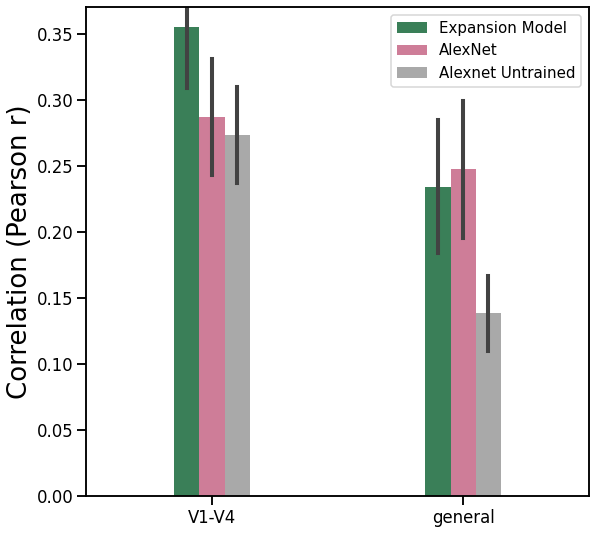

In [19]:
#regions = ['general']
dataset = 'naturalscenes'

mode = 'ridgecv'
MAX_POOL = True

data_dicts = {
    
    'regions':[['V1'], ['general']],
    'data_dict':[
        {
    
    
    'expansion model 3L 10000':{
                'iden':'expansion_model',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL}, 
    
    
       'alexnet conv3':{
                'iden':'alexnet_conv3',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':384,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL}, 

        'alexnet u conv4':{
                'iden':'alexnet_u_conv4',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':4,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL}
    },
    {  
        'expansion model 3L 10000':{
                'iden':'expansion_model',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':3,
                'num_features':10000,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL}, 
    
    'alexnet':{
                'iden':'alexnet_conv5',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'n_dims': None,
                'num_features':256,
                'max_pool':MAX_POOL},         
        
        'alexnet u':{
                'iden':'alexnet_u_conv5',
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None}
    }]
}


name_dict = {'expansion_model':'Expansion Model',
           'alexnet':'AlexNet',
           'alexnet_u': 'Alexnet Untrained'
           
          }

palette = {'Expansion Model':'seagreen',
           'AlexNet':'palevioletred',
           'Alexnet Untrained': 'darkgray'
           
          }

plot_data_means_vs_regions(data_dicts, dataset, mode, x_axis = 'region',  palette = palette, ylim = (0.0, 0.37),
                                params = (9,9), width = 0.3, show_legend= True, name_dict= name_dict, file_name= 'performance per region')

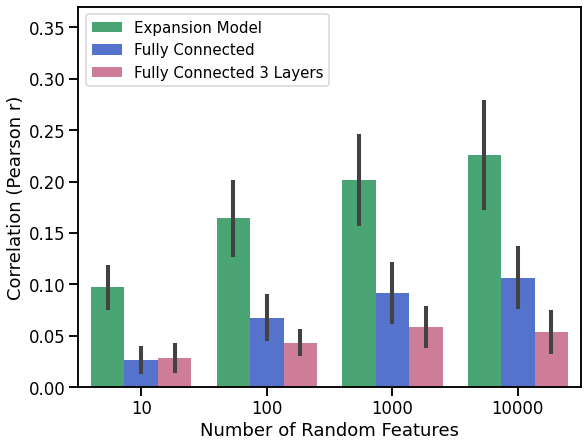

In [24]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
    
        'model abs 3x3 bp 224 ap 10 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 10, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

        'model abs 3x3 bp 224 ap 100 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 100, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':100,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
        'model abs 3x3 bp 224 ap 1000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':1000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    

        'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
  
    # 'fully random 10000':{
    #             'iden':'fully_random',
    #             #'model':FRModel(filters_1 = 1000, filters_3 = 10000, device=torch.device('cpu')).Build(),
    #             'layers': ['last'], 
    #             'preprocess':Preprocess(im_size=224).PreprocessGS, 
    #             'num_layers':3,
    #             'num_features':10000,
    #             'dim_reduction_type':None,
    #             'n_dims': None,
    #             'max_pool':MAX_POOL,
    #             'alphas': 'fully_random'},  
    
    'fully connected 10':{
                'iden':'fully_connected',
                #'model':FCModel(image_size = 224, num_features = 10).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':10,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected'}, 
    
    'fully connected 100':{
                'iden':'fully_connected',
                #'model':FCModel(image_size = 224, num_features = 100).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':100,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected'}, 
    
    'fully connected 1000':{
                'iden':'fully_connected',
                #'model':FCModel(image_size = 224, num_features = 1000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':1000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected'}, 
    
    'fully connected':{
                'iden':'fully_connected',
                #'model':FCModel(image_size = 224, num_features = 10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':10000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected'},

    
    'fully connected 3 layers 10':{
                'iden':'fully_connected_3l',
                #'model':FCModel3L(image_size = 224, features_3=10).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected_3L'},     
    
    
    'fully connected 3 layers 100':{
                'iden':'fully_connected_3l',
                #'model':FCModel3L(image_size = 224, features_3=100).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':100,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected_3L'}, 
    
    
    'fully connected 3 layers 1000':{
                'iden':'fully_connected_3l',
                #'model':FCModel3L(image_size = 224, features_3=1000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':1000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected_3L'}, 
        
        
    'fully connected 3 layers':{
                'iden':'fully_connected_3l',
                #'model':FCModel3L(image_size = 224).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':False,
                'alphas': 'fully_connected_3L'}, 
           
}   




name_dict = {'model_abs_3x3_bp_224_ap':'Expansion Model',
             'fully_connected': 'Fully Connected',
             'fully_connected_3l': 'Fully Connected 3 Layers'
            }


palette = {'Expansion Model':'mediumseagreen',
           'Fully Connected':'royalblue',
           'Fully Connected 3 Layers': 'palevioletred'
           
          }


plot_data_means_vs_features(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, palette= palette, baseline_palette = None,
                            error_bars = False, ylim = (0.0, 0.37), width=0.8,show_legend = True,
                            params= (9,7), xlog = False, x_axis = 'num_features', 
                            file_name =  f'fully connected vs expansion mdoel')

# Plot diff number of layers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


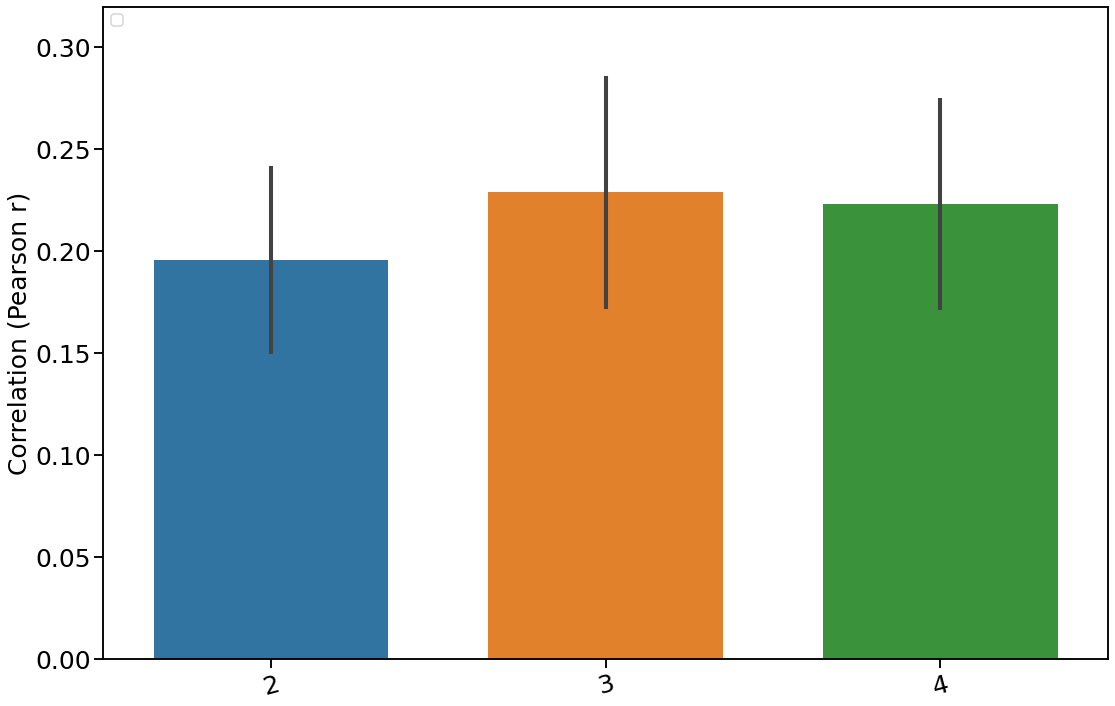

In [23]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
    
    
        
    'expansion model 2L':{
                'iden':'expansion_model',
                #'model':ExpansionModel2L(filters_2=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':2,
                'num_features':10000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'diff_num_layers'}, 
    
    'expansion model 3L':{
                'iden':'expansion_model',
                #'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'diff_num_layers'},     
    
    'expansion model 4L':{
                'iden':'expansion_model',
                #'model':ExpansionModel4L(filters_4=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':4,
                'num_features':10000,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'diff_num_layers'},   

           
}   




name_dict = None


palette = None


plot_diff_layers(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, baseline_palette = None,
                            error_bars = False, ylim = (0.0, 0.32), width=0.7,show_legend = True,
                            params= (18,12), xlog = False, x_axis = 'num_features', 
                            file_name =  'diff num layers')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


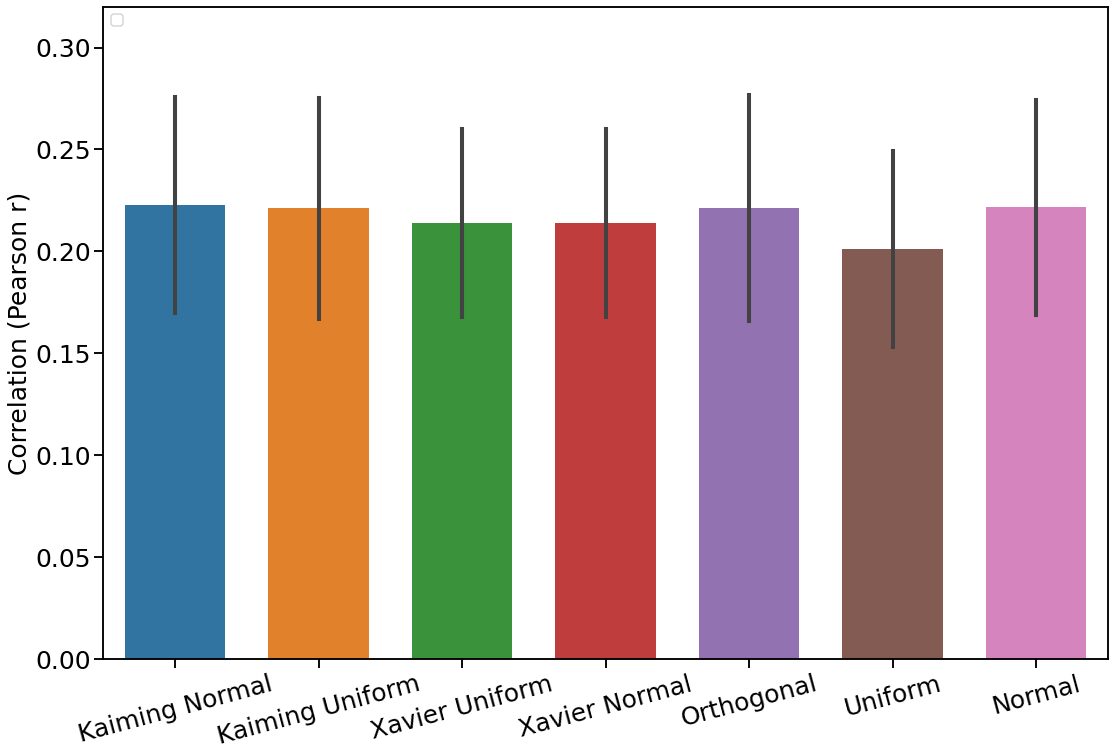

In [64]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
    
    
    'Expansion Model kaiming normal':{
                'iden':'model_abs_3x3_bp_224_ap_kaiming_normal',
                #'model':ExpansionModel(init_type = 'kaiming_normal', gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},  
    
    'Expansion Model kaiming unioform':{
                'iden':'model_abs_3x3_bp_224_ap_kaiming_uniform',
                #'model':ExpansionModel(init_type = 'kaiming_uniform', gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},  
    
    'Expansion Model Xavier Unioform':{
                'iden':'model_abs_3x3_bp_224_ap_xavier_uniform',
                #'model':ExpansionModel(init_type = 'xavier_uniform', gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},    
    
    'Expansion Model Xavier normal':{
                'iden':'model_abs_3x3_bp_224_ap_xavier_normal',
                #'model':ExpansionModel(init_type = 'xavier_normal', gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},    
    
    'Expansion Model Orthogonal':{
                'iden':'model_abs_3x3_bp_224_ap_orthogonal',
                #'model':ExpansionModel(init_type = 'orthogonal', filters_3 = 1000, gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},        
    
        'Expansion Model Uniform':{
                'iden':'model_abs_3x3_bp_224_ap_uniform',
                #'model':ExpansionModel(init_type = 'uniform', filters_3 = 1000, gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},    

            'Expansion Model Normal':{
                'iden':'model_abs_3x3_bp_224_ap_normal',
                #'model':ExpansionModel(init_type = 'normal', filters_3 = 1000, gpool = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_initializations'},  

           
}   




name_dict = {
             'model_abs_3x3_bp_224_ap_normal':'Normal',
             'model_abs_3x3_bp_224_ap_uniform':'Uniform',
             'model_abs_3x3_bp_224_ap_xavier_normal':'Xavier Normal',
             'model_abs_3x3_bp_224_ap_xavier_uniform':'Xavier Uniform',
             'model_abs_3x3_bp_224_ap_kaiming_normal':'Kaiming Normal',
             'model_abs_3x3_bp_224_ap_kaiming_uniform':'Kaiming Uniform',
             'model_abs_3x3_bp_224_ap_orthogonal':'Orthogonal',
                         }


palette = None
initializations(

plot_diff_models(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, baseline_palette = None,
                            error_bars = False, ylim = (0.0, 0.32), width=0.7,show_legend = True,
                            params= (18,12), xlog = False, x_axis = 'num_features', 
                            file_name =  f'diff init')

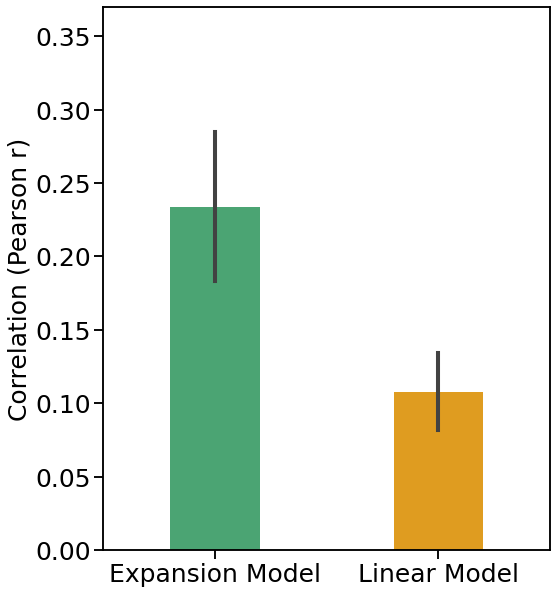

In [13]:

dataset = 'naturalscenes'
regions = ['general']
#regions = ['V1','V2','V3','V4']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'ridgecv'
MAX_POOL = True
data_dict = {  
    
    

    'expansion model 3L 10000':{
                'iden':'expansion_model_final',
               # 'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL,
                },
    
    'model linear 10000':{
                'iden':'model_linear',
                #'model':LinearModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL},
           
}   




name_dict = {'expansion_model_final':'Expansion Model',
             'model_linear': 'Linear Model'

                         }


palette = {'Expansion Model':'mediumseagreen',
            'Linear Model':'orange'}

plot_diff_models(data_dict, dataset, regions, mode, name_dict = name_dict, color = None, palette = palette,
                            error_bars = False, ylim = (0.0, 0.37), width=0.4,show_legend = False,
                            params= (8,10), xlog = False, x_axis = 'num_features', 
                            file_name =  f'linear_vs_non_linear')

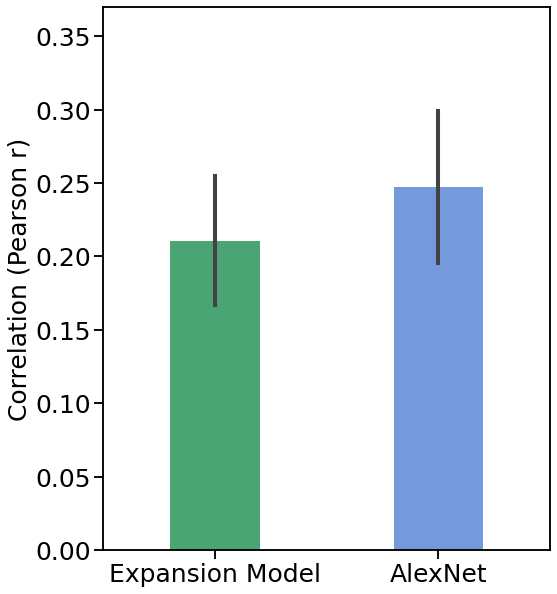

In [12]:

dataset = 'naturalscenes'
regions = ['general']
#regions = ['V1','V2','V3','V4']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'ridgecv'
MAX_POOL = True
data_dict = {  
    
    


    'model linear 10000':{
                'iden':'expansion_model_final_pca',
                #'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'n_dims': None,
                'num_layers':3,
                'num_features':10000,
                'max_pool':MAX_POOL},
    
    
       'alexnet conv5':{
                'iden':'alexnet_conv5',
                #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL}, 
           
}   




name_dict = {'expansion_model_final_pca':'Expansion Model',
             'alexnet_conv5': 'AlexNet'

                         }


palette = {'Expansion Model':'mediumseagreen',
            'AlexNet':'cornflowerblue'}

plot_diff_models(data_dict, dataset, regions, mode, name_dict = name_dict, color = None, palette = palette,
                            error_bars = False, ylim = (0.0, 0.37), width=0.4,show_legend = False,
                            params= (8,10), xlog = False, x_axis = 'num_features', 
                            file_name =  f'model_pcs_vs_alexnet')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


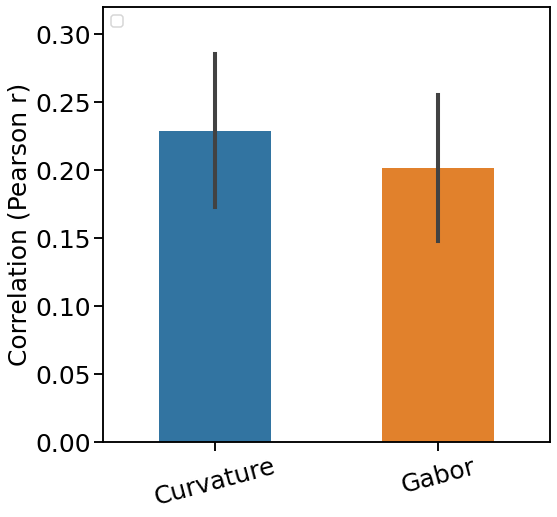

In [30]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
    

    'expansion model 3L':{
                'iden':'expansion_model',
                #'model':ExpansionModel(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'diff_num_layers'},      
    
    
    'expansion model gabor':{
                'iden':'expansion_model_gabor',
                #'model':ExpansionModelGabor(filters_3=10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'gabor_model'},      

           
}   




name_dict = {
             'expansion_model':'Curvature',
             'expansion_model_gabor':'Gabor'
}


palette = None

plot_initializations(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, baseline_palette = None,
                            error_bars = False, ylim = (0.0, 0.32), width=0.5,show_legend = True,
                            params= (8,8), xlog = False, x_axis = 'num_features', 
                            file_name =  f'gabor vs curvature')

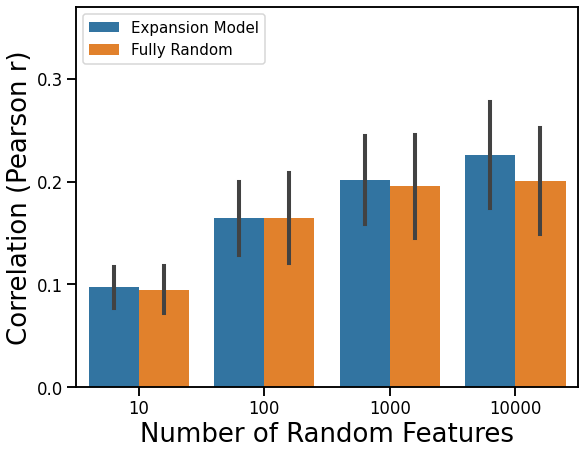

In [10]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['IT']

mode = 'test'
MAX_POOL = True
data_dict = {  
    
        'model abs 3x3 bp 224 ap 10 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 10, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

        'model abs 3x3 bp 224 ap 100 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 100, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':100,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
        'model abs 3x3 bp 224 ap 1000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':1000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    

        'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  
    
    
    'fully random 10':{
                'iden':'fully_random_36',
                #'model':FRModel(filters_3 = 10, device=torch.device("cpu")).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':10,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'fully_random_3L'}, 
    
    'fully random 100':{
                'iden':'fully_random_36',
                #'model':FRModel(filters_3 = 100, device=torch.device("cpu")).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':100,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'fully_random_3L'}, 
    
    'fully random 1000':{
                'iden':'fully_random_36',
                #'model':FRModel(filters_3 = 1000, device=torch.device("cpu")).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':1000,
                'n_dims': None,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'alphas': 'fully_random_3L'}, 
    
    'fully random 10000':{
                'iden':'fully_random_36',
                #'model':FRModel(filters_3 = 10000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':1,
                'num_features':10000,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'fully_random_3L'}, 
          
}   




name_dict = {
             'model_abs_3x3_bp_224_ap':'Expansion Model',
             'fully_random_36':'Fully Random',
                         }


palette = None


plot_data_means_vs_features(data_dict, dataset, regions, mode, baseline_dict  = None,
                            name_dict = name_dict, palette= palette, baseline_palette = None,
                            error_bars = False, ylim = (0.0, 0.37), width=0.8,show_legend = True,
                            params= (9,7), xlog = False, x_axis = 'num_features', 
                            file_name =  f'fully random vs expansion mdoel')





## pca

### np max pool

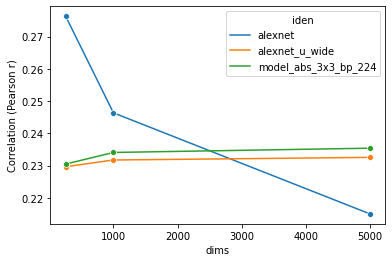

In [15]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = False

data_dict = {                  
        
            'alexnet 256 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'}, 
    
            'alexnet 1000 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'}, 

    
            'alexnet 5000 pcs':{
                'iden':'alexnet',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_pca'},   
    
            'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'}, 
    
            'alexnet u wide 1000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'}, 

    
            'alexnet u wide 5000 pcs':{
                'iden':'alexnet_u_wide',
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_pca'},   

        
    
    
                 'model abs 3x3 bp 224 256 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 
    
    
                    
                 'model abs 3x3 bp 224 1000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 

    
                'model abs 3x3 bp 224 5000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3=10000,n_components=5000).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca':True,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224'}, 

}

plot_data_means_vs_features(data_dict, dataset, region, mode, file_name =' pca no max pool', show_legend=False)

### max pool

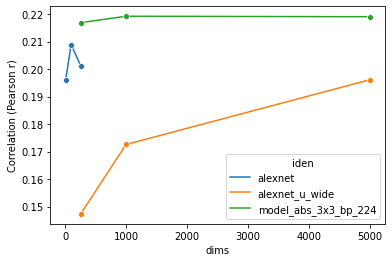

In [10]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = True
data_dict = {  
        'alexnet 10 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':10,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 

        'alexnet 100 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':100,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 
    
        'alexnet 256 pcs':{
                'iden':'alexnet',
                #'model':AlexnetPCA(n_components=256, global_mp = MAX_POOL).Build(),
                'layers': ['pca5'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':256,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp_pca'}, 
    
        'alexnet u wide 256 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'}, 

        'alexnet u wide 1000 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'},     
        
         
        'alexnet u wide 5000 pcs':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetUPCA(n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_wide_mp_pca'}, 
        
    'model abs 3x3 bp 224 256 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':256,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'}, 

        'model abs 3x3 bp 224 1000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':1000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'},   
        
         
        'model abs 3x3 bp 224 5000 pcs':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBPPCA(filters_3 = 10000, n_components=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'pca_dataset':'nsd',
                'n_dims':5000,
                'max_dims':5000,
                'dim_reduction_type':'pca',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_mp_pca'}, 
}   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name =  'pca max pool', show_legend=False)

## random projections

### no max pool

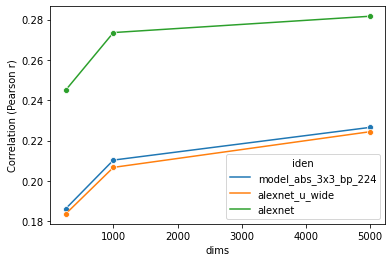

In [12]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = False
data_dict = {  
    'model abs 3x3 bp 224 256 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'},  

        'model abs 3x3 bp 224 1000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':1000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'},  
        
         
        'model abs 3x3 bp 224 5000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'n_dims':5000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_rp'}, 
    
    
            'alexnet u wide 256 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_u_wide_rp'},  

    
    
       'alexnet u wide 1000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_u_wide_rp'},  
        
    
         
       'alexnet u wide 5000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_u_wide_rp'}, 

        'alexnet 256 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_rp'},  

    
    
        'alexnet 1000 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_rp'},    
        
    
         
        'alexnet 5000 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_rp'},
}   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name = 'random projections no max pool', show_legend=False)

### max pool

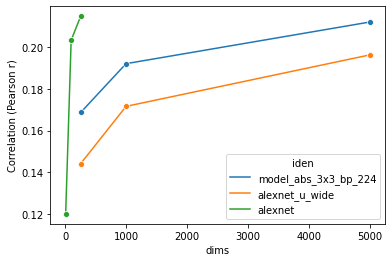

In [9]:
dataset = 'naturalscenes'
region = 'V4'
mode = 'test'
MAX_POOL = True
data_dict = { 
    'model abs 3x3 bp 224 256 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'max_dims':256,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},  

    
    
        'model abs 3x3 bp 224 1000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'max_dims':1000,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},  
        
    
         
        'model abs 3x3 bp 224 5000 rps':{
                'iden':'model_abs_3x3_bp_224',
                #'model':EngModel3LAbsBP(filters_3 = 10000, num_projections=5000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool': MAX_POOL,
                'n_dims':5000,
                'max_dims':5000,
                'alphas': 'model_abs_3x3_bp_224_mp_rp'},     

        'alexnet u wide 256 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_u_wide_mp_rp'},  

    
    
       'alexnet u wide 1000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':1000,
                'alphas': 'alexnet_u_wide_mp_rp'},  
        
    
         
        'alexnet u wide 5000 rps':{
                'iden':'alexnet_u_wide',
                #'model':AlexnetU(filters_5 = 10000, num_projections=256 global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':10000,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':5000,
                'alphas': 'alexnet_u_wide_mp_rp'},       
    
    
        'alexnet 10 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=10, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':10,
                'alphas': 'alexnet_mp_rp'},  

    
    
        'alexnet 100 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=100, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':100,
                'alphas': 'alexnet_mp_rp'},    
        
    
         
        'alexnet 256 rps':{
                'iden':'alexnet',
                #'model':Alexnet(num_projections=256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':'rp',
                'max_pool':MAX_POOL,
                'n_dims':256,
                'alphas': 'alexnet_mp_rp'},   
    }   
    
plot_data_means_vs_features(data_dict, dataset, region, mode, file_name = 'random projections maxpool', show_legend=False)

# Per subject analysis

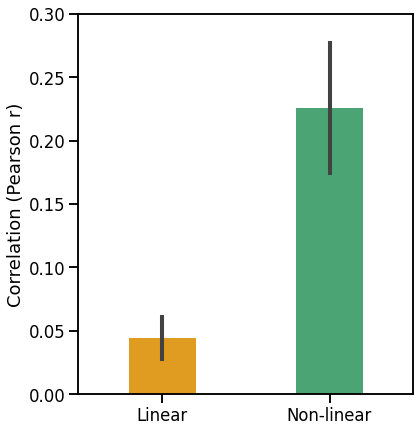

In [111]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

baseline_dict = {
    'model 3x3 bp 224 ap 10000 filters':{
                'iden':'model_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_3x3_bp_224_ap_mp'},   
    
    
    'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

}
        

name_dict =  {'model_3x3_bp_224_ap':'Linear',
             'model_abs_3x3_bp_224_ap':'Non-linear'}

baseline_palette = {'Non-linear':'mediumseagreen', 
           'Linear':'orange'}
plt.clf()
plot_baselines(dataset, regions, mode,  aspect = 0.4, height =6.5, show_legend= False, ylim = (0.0, 0.3), width = 0.4,
                                params= (8,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name = 'linear vs non linear')

<Figure size 432x288 with 0 Axes>

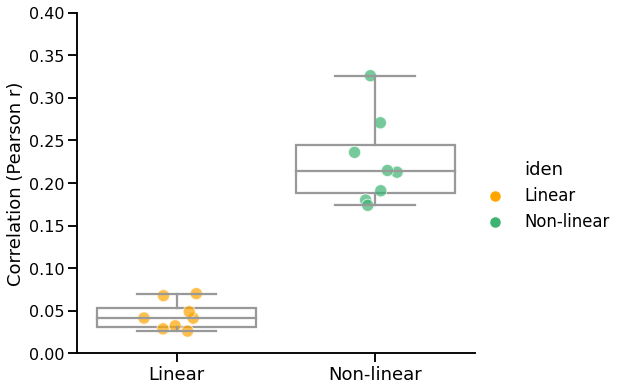

In [153]:
dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

data_dict = {
    'model 3x3 bp 224 ap 10000 filters':{
                'iden':'model_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_3x3_bp_224_ap_mp'},   
    
    
    'model abs 3x3 bp 224 ap 10000 filters':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'model_abs_3x3_bp_224_ap_mp'},  

}
        
name_dict = {'model_3x3_bp_224_ap':'Linear',
             'model_abs_3x3_bp_224_ap':'Non-linear'}

model_nums = {'Non-linear':1, 'Linear':0}

palette = {'Non-linear':'mediumseagreen', 
           'Linear':'orange'}


plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=1.2, size=150, 
                       params = (6,4), name_dict = name_dict, file_name = 'linear vs non linear', show_legend = False) 
  

<Figure size 432x288 with 0 Axes>

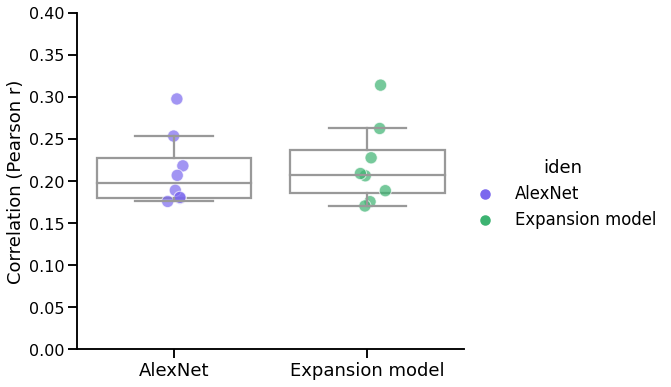

In [154]:
dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

data_dict = {
            'alexnet':{
                'iden':'alexnet',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},   
    
    
        'model abs 3x3 bp 224 ap 256 pcs':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAPPCA(filters_3 = 10000, n_components= 256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'pca',
                'n_dims':256,
                'max_dims':256,
                'pca_dataset':'nsd',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_ap_mp_pca'},

}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion model',
             'alexnet':'AlexNet'}

palette = {'AlexNet':'orange', 'Expansion model':'green'}


model_nums = {'Expansion model':1, 'AlexNet':0}

palette = {'AlexNet':'mediumslateblue', 
           'Expansion model':'mediumseagreen'}


plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=1.2, size=150, 
                       params = (6,4), name_dict = name_dict, file_name = 'alexnet vs model', show_legend = False) 


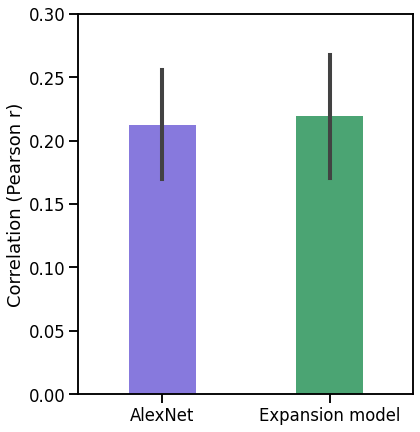

In [108]:
dataset = 'naturalscenes'
regions = ['V4']
#regions = ['general']
# dataset = 'majajhong'
# regions = ['V4']

mode = 'test'
MAX_POOL = True

dataset = 'naturalscenes'
regions = ['V4']
mode = 'test'
MAX_POOL = True

baseline_dict = {
            'alexnet':{
                'iden':'alexnet',
                #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'max_pool':MAX_POOL,
                'n_dims': None,
                'alphas': 'alexnet_mp'},   
    
    
        'model abs 3x3 bp 224 ap 256 pcs':{
                'iden':'model_abs_3x3_bp_224_ap',
                #'model':EngModel3LAbsBPAPPCA(filters_3 = 10000, n_components= 256, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessGS, 
                'num_layers':3,
                'num_features':10000,
                'dim_reduction_type':'pca',
                'n_dims':256,
                'max_dims':256,
                'pca_dataset':'nsd',
                'max_pool':MAX_POOL,
                'alphas': 'model_abs_3x3_bp_224_ap_mp_pca'},

}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion model',
             'alexnet':'AlexNet'}

baseline_palette = {'AlexNet':'mediumslateblue', 
           'Expansion model':'mediumseagreen'}        


plt.clf()
plot_baselines(dataset, regions, mode,  aspect = 0.5, height =6.5, show_legend= False, ylim = (0.0, 0.3), width =0.4,
                                params= (6,7), baseline_dict = baseline_dict, baseline_palette = baseline_palette,
                                name_dict= name_dict, file_name = 'alexnet vs model')

<Figure size 432x288 with 0 Axes>

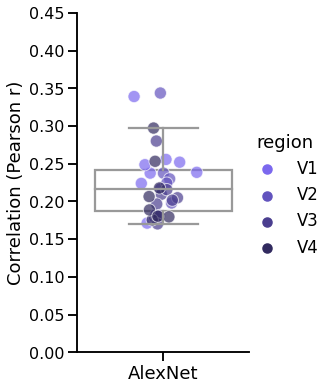

In [88]:
dataset = 'naturalscenes'
regions = ['V1','V2','V3','V4']
mode = 'test'
MAX_POOL = True

data_dict = {
    
#         'model abs 3x3 bp 224 ap 10000 filters':{
#                 'iden':'model_abs_3x3_bp_224_ap',
#                 #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessGS, 
#                 'num_layers':3,
#                 'num_features':10000,
#                 'dim_reduction_type':None,
#                 'max_pool':MAX_POOL,
#                 'n_dims': None,
#                 'alphas': 'model_abs_3x3_bp_224_ap_mp'}, 
    
       'alexnet':{
                'iden':'alexnet',
                #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_mp'},     
    
        # 'alexnet u':{
        #         'iden':'alexnet_u',
        #         #'model':AlexnetU(features_layer =9, global_mp = MAX_POOL).Build(),
        #         'layers': ['last'], 
        #         'preprocess':Preprocess(im_size=224).PreprocessRGB, 
        #         'num_layers':5,
        #         'num_features':256,
        #         'dim_reduction_type':None,
        #         'n_dims': None,
        #         'max_pool':MAX_POOL,
        #         'alphas': 'alexnet_u_mp'},  
    
    
 


}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion Model',
             'alexnet':'AlexNet',
             'alexnet_u':'AlexNet Untrained'}
            
# palette = {'Expansion Model':'mediumseagreen', 
#            'AlexNet':'mediumslateblue', 
#            'AlexNet Untrained': 'darkgray'}


import matplotlib.colors as mcolors
model_name = 'AlexNet'
color = 'mediumslateblue'

# model_name = 'Expansion Model'
# color = 'mediumseagreen'

# model_name = 'AlexNet Untrained'
# color = 'darkgray'


rgb = mcolors.to_rgb(color)
V2_color = tuple([min(max(0, c * 0.8), 1) for c in rgb])
V3_color = tuple([min(max(0, c * 0.6), 1) for c in rgb])
V4_color = tuple([min(max(0, c * 0.4), 1) for c in rgb])
             
palette = {'V1':color, 
           'V2':V2_color, 
           'V3':V3_color, 
           'V4':V4_color,  
          }             
             
model_nums = None #{'Expansion Model':1}, #'AlexNet':1, 'AlexNet Untrained':2}



plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, 
                   palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=0.7, size=150, ylim = (0.0, 0.45),
                   name_dict = name_dict, file_name = f'{model_name} - boxplot - {regions}', show_legend = False) 





<Figure size 432x288 with 0 Axes>

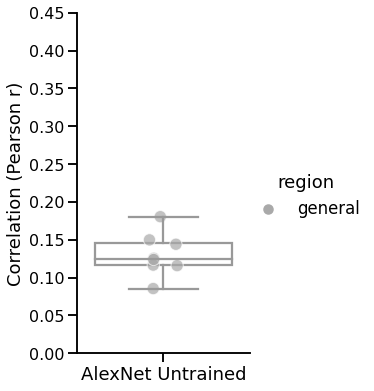

In [90]:
V1_colordataset = 'naturalscenes'
regions = ['general']
mode = 'test'
MAX_POOL = True

data_dict = {
    
        # 'model abs 3x3 bp 224 ap 10000 filters':{
        #         'iden':'model_abs_3x3_bp_224_ap',
        #         #'model':EngModel3LAbsBPAP(filters_3 = 1000, global_mp = MAX_POOL).Build(),
        #         'layers': ['last'], 
        #         'preprocess':Preprocess(im_size=224).PreprocessGS, 
        #         'num_layers':3,
        #         'num_features':10000,
        #         'dim_reduction_type':None,
        #         'max_pool':MAX_POOL,
        #         'n_dims': None,
        #         'alphas': 'model_abs_3x3_bp_224_ap_mp'}, 
    
#        'alexnet':{
#                 'iden':'alexnet',
#                 #'model':Alexnet(features_layer =7, global_mp = MAX_POOL).Build(),
#                 'layers': ['last'], 
#                 'preprocess':Preprocess(im_size=224).PreprocessRGB, 
#                 'num_layers':5,
#                 'num_features':256,
#                 'dim_reduction_type':None,
#                 'n_dims': None,
#                 'max_pool':MAX_POOL,
#                 'alphas': 'alexnet_mp'},     
    
        'alexnet u':{
                'iden':'alexnet_u',
                #'model':AlexnetU(features_layer =9, global_mp = MAX_POOL).Build(),
                'layers': ['last'], 
                'preprocess':Preprocess(im_size=224).PreprocessRGB, 
                'num_layers':5,
                'num_features':256,
                'dim_reduction_type':None,
                'n_dims': None,
                'max_pool':MAX_POOL,
                'alphas': 'alexnet_u_mp'},  
    
    
 


}
        
name_dict = {'model_abs_3x3_bp_224_ap':'Expansion Model',
             'alexnet':'AlexNet',
             'alexnet_u':'AlexNet Untrained'}
            
# palette = {'Expansion Model':'mediumseagreen', 
#            'AlexNet':'mediumslateblue', 
#            'AlexNet Untrained': 'darkgray'}


import matplotlib.colors as mcolors
# model_name = 'AlexNet'
# color = 'mediumslateblue'

# model_name = 'Expansion Model'
# color = 'mediumseagreen'

model_name = 'AlexNet Untrained'
color = 'darkgray'    


palette = {'general':color, 
          }             
             
model_nums = None #{'Expansion Model':1}, #'AlexNet':1, 'AlexNet Untrained':2}



plot_subject_means(data_dict = data_dict, dataset=dataset, regions=regions, mode=mode, 
                   palette=palette, model_nums=model_nums, 
                   opacity=0.7, height=6, aspect=0.7, size=150, ylim = (0.0, 0.45),
                   name_dict = name_dict, file_name = f'{model_name} - boxplot - {regions}', show_legend = False) 





In [ ]:
root_path = 
region = 
subject = 


